In [1]:
from datetime import date
from glob import glob
import json
import math
import os
import pickle
import sys
import time

import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import integrate, interpolate, stats

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_events_wdict, qualitycheck_trials, find_nearest_ind
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

In [5]:
plotdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\EP_temporal_analysis'

#### Load excel sheet with metadata for experiments

In [6]:
_gc = gspread.service_account() # need a key file to access the account
## Load Templeton log ##
_sh = _gc.open('Templeton-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
Temp_metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe
## Load Zap&zip log ##
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
ZZ_metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

### Load subject

In [7]:
multisub_file = r"C:\Users\lesliec\OneDrive - Allen Institute\data\brain_states_subjects_2024_06.csv"
subject_df = pd.read_csv(multisub_file, converters={'mouse': str}).astype({'analyze_EEG': bool, 'analyze_NPX': bool})
subject_df.head()

,exp_type,mouse,experiment,sweep_states,bad_chs,analyze_EEG,analyze_NPX,CCF_res,notes
0,urethane,582386,urethane_2021-07-15_11-36-58,urethane,"0,2,3",True,True,10,NaN
1,urethane,638703,urethane_estim_2022-10-14_12-25-20,urethane,"0,3,4,6,7,11,13",True,True,25,NaN
2,urethane,654181,urethane_vis_2022-11-23_08-30-16,urethane,"7,8,11,13",True,True,25,NaN
3,urethane,654182,urethane_vis_2022-12-02_11-02-25,urethane,"3,6,14,22,23",True,True,25,NaN
4,urethane,631037,urethane_2022-12-07_10-34-51,urethane,"6,7,8,21",True,True,25,NaN


In [8]:
subrow = subject_df.iloc[16]
print('{} - {} exp'.format(subrow.mouse, subrow.exp_type))

673449 - psilocybin exp


In [9]:
dfolder = os.path.join('F:\psi_exp', 'mouse' + subrow.mouse, subrow.experiment, 'experiment1', 'recording1')
exp = EEGexp(dfolder, preprocess=False, make_stim_csv=False)
exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print('{} - {}'.format(exp.mouse, exp_tag))

Experiment type: electrical stimulation
673449 - aw_psi_d2


In [10]:
## Grab exp metadata from log_exp ##
if np.any([True if subrow.mouse in x else False for x in np.unique(Temp_metadata['mouse_name'].values)]):
    exp_meta = Temp_metadata[(
        (Temp_metadata['mouse_name'].str.contains(subrow.mouse)) & (Temp_metadata['exp_name'].str.contains(subrow.experiment))
    )].squeeze()
elif np.any([True if subrow.mouse in x else False for x in np.unique(ZZ_metadata['mouse_name'].values)]):
    exp_meta = ZZ_metadata[(
        (ZZ_metadata['mouse_name'].str.contains(subrow.mouse)) & (ZZ_metadata['exp_name'].str.contains(subrow.experiment))
    )].squeeze()
else:
    print('Cannot find {}: {} in the experiment log excel sheets.'.format(subrow.mouse, subrow.experiment))
    
## Get bad EEG channels ##
badchstr = exp_meta['EEG bad_channels'].replace(' ','')
bad_chs = []
for char in badchstr.split(','):
    if char.isdecimal():
        bad_chs.append(int(char))
print(bad_chs)
## Get injection times ##
try:
    inj_times = [float(exp_meta['First injection time (s)']), float(exp_meta['Second injection time (s)'])]
    print(inj_times)
except:
    inj_times = None

[13, 14]
[1149.93, 1837.79]


Re-check trial signal quality

Load stim log

In [11]:
stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
stim_log.head()

,stim_type,parameter,duration,onset,offset,sweep,good,mean_speed,resting_trial
0,biphasic,40,0.0004,167.17785,167.17825,0,True,3.454908,False
1,biphasic,40,0.0004,173.78494,173.78534,0,True,0.167051,False
2,biphasic,40,0.0004,181.24728,181.24768,0,True,0.000000,True
3,biphasic,40,0.0004,187.75236,187.75276,0,True,0.000000,True
4,biphasic,40,0.0004,195.02772,195.02812,0,True,0.098712,False


Load EEG all event traces

In [12]:
all_EEG_traces = np.load(os.path.join(exp.data_folder, 'evoked_data', 'event_EEGtraces.npy'))
EEG_event_timestamps = np.load(os.path.join(exp.data_folder, 'evoked_data', 'event_EEGtraces_times.npy'))
eeg_chs = np.arange(0, all_EEG_traces.shape[1])
good_chs = np.array([x for x in eeg_chs if x not in bad_chs])
print(len(good_chs))

28


Load NPX units event spikes

In [13]:
unit_threshold = 10 # must have at least this number of units to be included in analysis
time_bin = 0.005 # size of time bins (s) for firing rate

In [14]:
## Load unit info ##
fn_units_info = os.path.join(exp.data_folder, 'evoked_data', 'all_units_info.csv')
if os.path.exists(fn_units_info):
    unit_info = pd.read_csv(fn_units_info)
    with open(os.path.join(exp.data_folder, 'evoked_data', 'units_event_spikes.pkl'), 'rb') as unit_file:
        all_unit_event_spikes = pickle.load(unit_file)
else:
    print('{} not found. Not analyzing this subject.'.format(fn_units_stats))
#     continue

## Make time bins for event spikes ##
bins = np.arange(all_unit_event_spikes['event_window'][0], all_unit_event_spikes['event_window'][1] + time_bin, time_bin)
timex = bins[:-1] + time_bin/2

unit_info.head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,parent_region
0,B0,probeB,0,3700,0.467002,PO,281,174,189,SM-TH
1,B1,probeB,0,3700,0.480737,PO,281,174,189,SM-TH
2,B5,probeB,1,3700,0.494472,PO,281,174,189,SM-TH
3,B6,probeB,1,3700,0.480737,PO,281,174,189,SM-TH
4,B7,probeB,1,3700,0.467002,PO,281,174,189,SM-TH


In [15]:
np.unique(unit_info['parent_region'].values)

array(['ACA', 'HIP', 'ILA', 'MO', 'OLF', 'PL', 'PTLp', 'RHP', 'RT-TH',
       'SM-TH', 'SS', 'VIS', 'other-TH'], dtype=object)

In [16]:
ROI_unit_info = {}
for region in np.unique(unit_info['parent_region'].values):
    udf = unit_info[unit_info['parent_region'] == region]
    if len(udf) >= unit_threshold:
        ROI_unit_info[region] = udf.sort_values(by='depth').reset_index(drop=True)
        print('{}: {:d} units'.format(region, len(udf)))

ACA: 30 units
HIP: 91 units
ILA: 82 units
MO: 61 units
OLF: 154 units
PL: 178 units
PTLp: 36 units
RHP: 75 units
SM-TH: 185 units
SS: 137 units
VIS: 118 units
other-TH: 278 units


Load and plot running and pupil

In [17]:
running_file = os.path.join(exp.data_folder, 'running_signal.npy')
running_ts_file = os.path.join(exp.data_folder, 'running_timestamps_master_clock.npy')

if os.path.exists(running_file) and os.path.exists(running_ts_file):
    speed = np.load(running_file)
    speedts = np.load(running_ts_file)

In [18]:
if len(glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)) > 0:
    pupil_file = glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)[0]
    pupildf = pd.read_csv(pupil_file)
    # pupildf.head()

    pupilts = pupildf.sync_time.values
    pupilD = pupildf.Largest_Radius.values
    eyeD = pupildf.Eye_Diameter.values

    ## Smooth pupil diameter ##
    smooth_pupil = np.zeros_like(pupilD)
    k = 15 # filter window is actually k*2+1
    for i in range(k, len(pupilD)-k-1):
        smooth_pupil[i] = np.mean(pupilD[i-k:i+k]) # each point is the average of k surrounding points
    smooth_pupil[:k] = pupilD[:k]
    smooth_pupil[-k-1:] = pupilD[-k-1:]
    normpupil = smooth_pupil / np.mean(eyeD)
else:
    print('No local Pupileye*.csv file. Check server.')
    normpupil = None

No local Pupileye*.csv file. Check server.


<IPython.core.display.Javascript object>


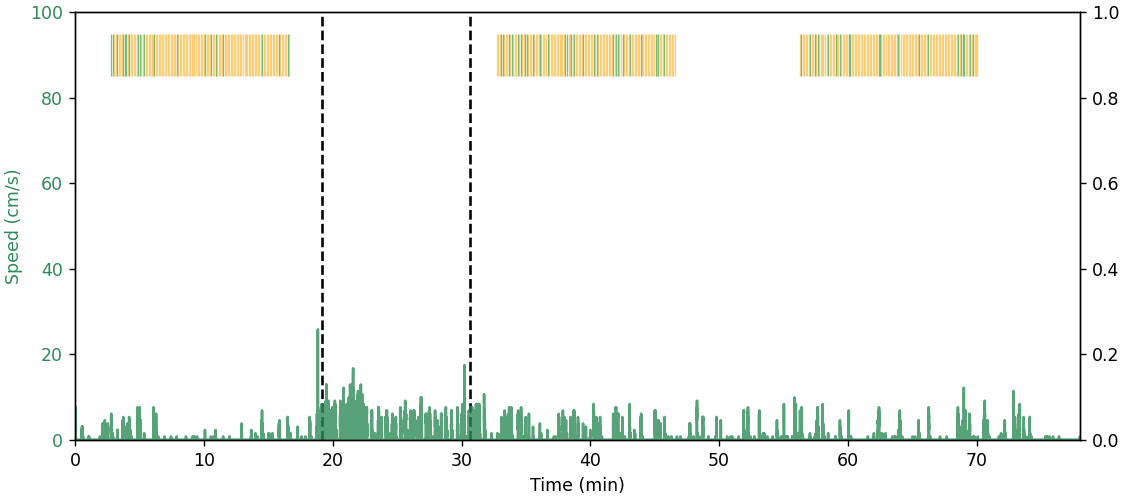

In [19]:
fig, ax = plt.subplots(figsize=(9,4), constrained_layout=True)

if inj_times is not None:
    for itime in inj_times:
        ax.axvline(itime/60, color='k', linestyle='dashed')

ax.plot(speedts/60, speed, 'seagreen', alpha=0.8)
ax.set_xlim([speedts[0]/60, speedts[-1]/60])
ax.set_xlabel('Time (min)')
ax.set_ylabel('Speed (cm/s)', color='seagreen')
ax.tick_params(axis='y', labelcolor='seagreen')
ax.set_ylim([0, 100])

ax2 = ax.twinx()
if normpupil is not None:
    ax2.plot(pupilts/60, normpupil, 'm', alpha=0.8)
    ax2.set_ylabel('Normalized pupil diameter', color='m')
    ax2.tick_params(axis='y', labelcolor='m')
ax2.set_ylim([0, 1])

## add stim times to plot ##
# for etype, ecol in zip(['biphasic', 'circle'], ['orange', 'blue']):
for rboo, rcol in zip([True, False], ['orange', 'green']):
    stimtimes = stim_log[(stim_log['stim_type'] == 'biphasic') & (stim_log['resting_trial'] == rboo)].onset.values / 60
    ax2.eventplot(stimtimes, colors=rcol, lineoffsets=0.9, linelengths=0.1, linewidths=0.75, alpha=0.5)

## Investigate EPs

In [20]:
stim_log.head()

,stim_type,parameter,duration,onset,offset,sweep,good,mean_speed,resting_trial
0,biphasic,40,0.0004,167.17785,167.17825,0,True,3.454908,False
1,biphasic,40,0.0004,173.78494,173.78534,0,True,0.167051,False
2,biphasic,40,0.0004,181.24728,181.24768,0,True,0.000000,True
3,biphasic,40,0.0004,187.75236,187.75276,0,True,0.000000,True
4,biphasic,40,0.0004,195.02772,195.02812,0,True,0.098712,False


In [21]:
np.unique(stim_log['parameter'].values)

array(['40'], dtype=object)

In [22]:
print('{:d} good trials out of {:d} total'.format(np.sum(stim_log.good.values), len(stim_log)))
print('{:d} resting trials out of {:d} total'.format(np.sum(stim_log.resting_trial.values), len(stim_log)))

339 good trials out of 360 total
294 resting trials out of 360 total


In [23]:
evtype = 'biphasic'
evpar = '40'

event_inds = get_events_wdict(stim_log, {'stim_type': evtype, 'parameter': evpar}, out='index')
event_traces = all_EEG_traces[:, :, event_inds]
## Apply common average reference ##
event_traces = event_traces - np.mean(event_traces[:, good_chs, :], axis=1)[:,None,:]

resting_trials = stim_log['resting_trial'].values[event_inds]
total_stims = len(get_events_wdict(stim_log, {'stim_type': evtype}, out='index'))

In [24]:
event_traces.shape

(10000, 30, 360)

## EEG metrics for trial sets

In [25]:
n_mean = 10

comp_dict = {'early': [0.003, 0.05], 'late': [0.15, 0.25], 'baseline': [-0.2, -0.1]}
compinfo = {'early': ['r', 'o'], 'mid': ['g', 's'], 'late': ['b', 'v'], 'baseline': ['gray', '<']}

In [26]:
# mean(trials) -> abs(values) -> mean(chs) #
## Average across every n_mean trials ##
if event_traces.shape[2] % n_mean == 0:
    num_trial_sets = int(event_traces.shape[2] / n_mean)
    n_mean_traces = np.mean(event_traces.reshape((event_traces.shape[0], event_traces.shape[1], -1, n_mean)), axis=-1)
    n_rest_trials = np.sum(resting_trials.reshape((-1, n_mean)), axis=-1)
else:
    print('Number of trials is not divisible by n_mean.')
## Then find mean across chs of the absolute value of trial averages ##
rect_mean = np.mean(np.abs(n_mean_traces[:, good_chs, :]), axis=1)

## Calculate PCI here?? Probably don't need this metric. ##

EP_metrics = {}
EP_metrics['n_rest_trials'] = n_rest_trials
EP_metrics['n_run_trials'] = n_mean - n_rest_trials
## Get rectified mean amplitude within test windows ##
for wini, windowi in comp_dict.items():
    testinds = np.nonzero((EEG_event_timestamps >= windowi[0]) & (EEG_event_timestamps <= windowi[1]))[0]
    mean_amp = np.mean(rect_mean[testinds, :], axis=0)
    EP_metrics[wini + '_mean_amp'] = mean_amp
    
EP_metrics_df = pd.DataFrame(EP_metrics)
EP_metrics_df.head()

,n_rest_trials,n_run_trials,early_mean_amp,late_mean_amp,baseline_mean_amp
0,5,5,47.784872,40.149725,5.985719
1,6,4,49.661132,36.197251,5.088494
2,8,2,45.803156,37.510381,8.635626
3,10,0,38.899974,24.048031,12.582100
4,9,1,36.521921,17.710174,12.012271


### Make combo summary plot

<IPython.core.display.Javascript object>


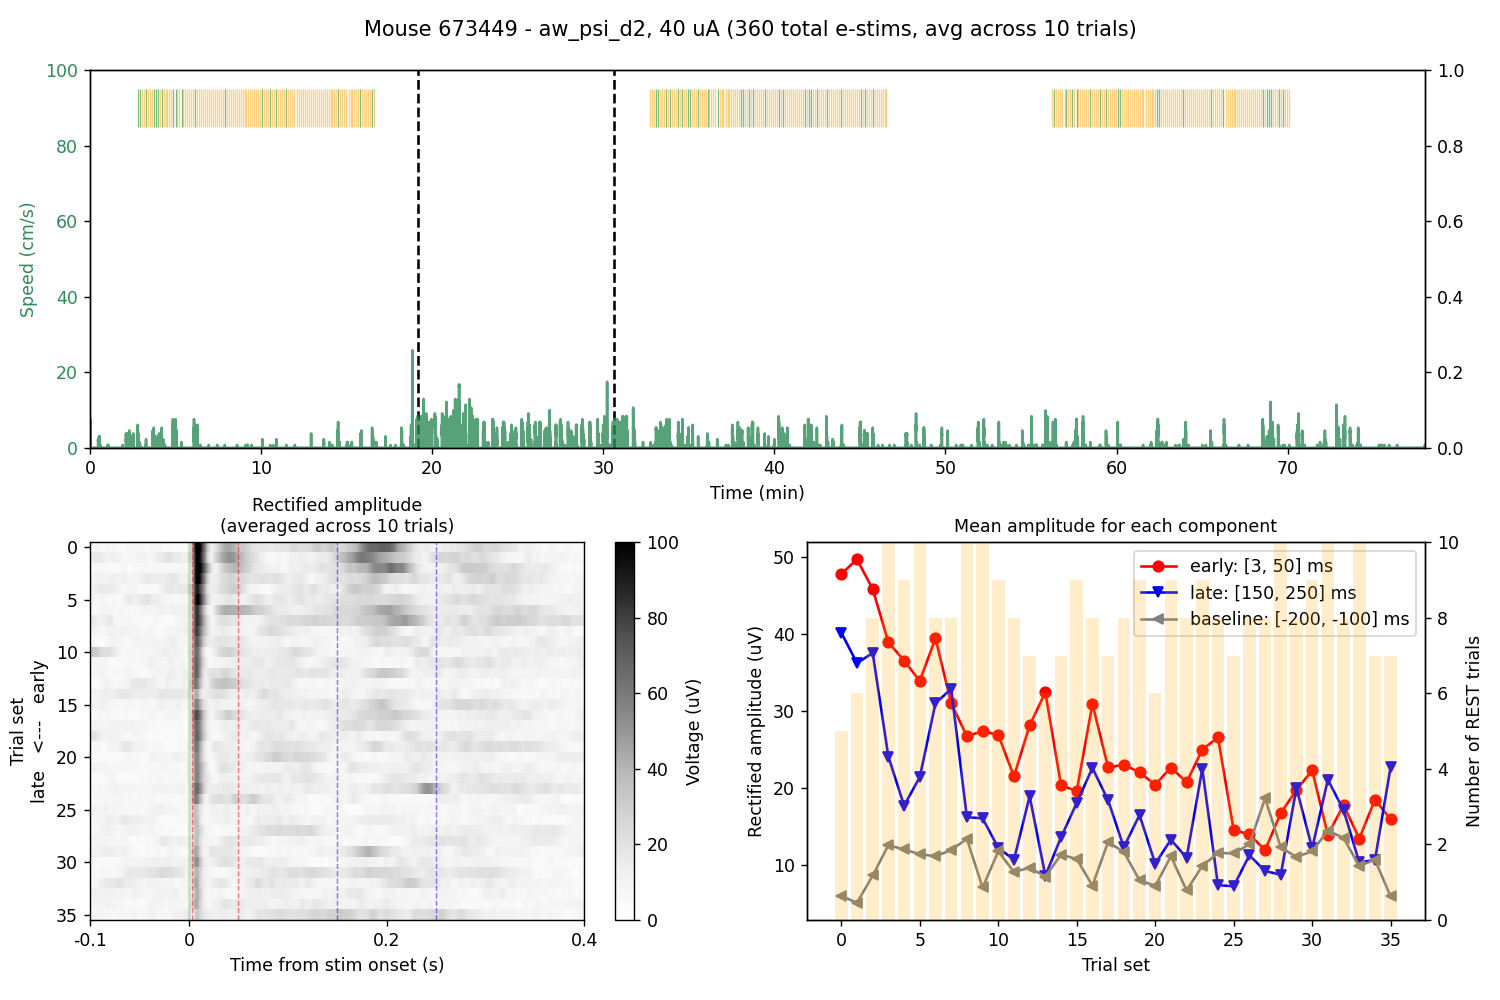

In [27]:
pwin = [-0.1, 0.4]
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(nrows=2, ncols=2, left=0.06, right=0.95, top=0.93, bottom=0.08, hspace=0.25, wspace=0.16)

axsp = fig.add_subplot(gs[0,:])
axim = fig.add_subplot(gs[1,0])
axamp = fig.add_subplot(gs[1,1])

## Plot speed, pupil, and estim times ##
if inj_times is not None:
    for itime in inj_times:
        axsp.axvline(itime/60, color='k', linestyle='dashed')

axsp.plot(speedts/60, speed, 'seagreen', alpha=0.8)
axsp.set_xlim([speedts[0]/60, speedts[-1]/60])
axsp.set_xlabel('Time (min)')
axsp.set_ylabel('Speed (cm/s)', color='seagreen')
axsp.tick_params(axis='y', labelcolor='seagreen')
axsp.set_ylim([0, 100])
        
axpup = axsp.twinx()
if normpupil is not None:
    axpup.plot(pupilts/60, normpupil, 'm', alpha=0.8)
    axpup.set_ylabel('Normalized pupil diameter', color='m')
    axpup.tick_params(axis='y', labelcolor='m')
axpup.set_ylim([0, 1])

for rboo, rcol in zip([True, False], ['orange', 'green']):
    stimtimes = stim_log[(stim_log['stim_type'] == 'biphasic') & (stim_log['resting_trial'] == rboo)].onset.values / 60
    axpup.eventplot(stimtimes, colors=rcol, lineoffsets=0.9, linelengths=0.1, linewidths=0.75, alpha=0.5)
    
## Plot trial set rectified average EPs ##
pwinind = [find_nearest_ind(EEG_event_timestamps, x) for x in pwin]
axim.axvline(find_nearest_ind(EEG_event_timestamps, 0), color='g', alpha=0.2)
vim = axim.imshow(rect_mean.T, cmap='Greys', interpolation='none', aspect='auto', vmin=0, vmax=100)
## Add Simone's windows ##
axim.axvline(find_nearest_ind(EEG_event_timestamps, 0.003), color='r', linewidth=0.8, linestyle='dashed', alpha=0.5)
axim.axvline(find_nearest_ind(EEG_event_timestamps, 0.05), color='r', linewidth=0.8, linestyle='dashed', alpha=0.5)
# axim.axvline(find_nearest_ind(EEG_event_timestamps, 0.08), color='g', linewidth=0.8, linestyle='dashed', alpha=0.5)
# axim.axvline(find_nearest_ind(EEG_event_timestamps, 0.2), color='g', linewidth=0.8, linestyle='dashed', alpha=0.5)
axim.axvline(find_nearest_ind(EEG_event_timestamps, 0.15), color='b', linewidth=0.8, linestyle='dashed', alpha=0.5)
axim.axvline(find_nearest_ind(EEG_event_timestamps, 0.25), color='b', linewidth=0.8, linestyle='dashed', alpha=0.5)
axim.set_xlim(pwinind)
new_ticks = [pwin[0], 0, np.mean([0, pwin[1]]), pwin[1]]
axim.set_xticks([find_nearest_ind(EEG_event_timestamps, x) for x in new_ticks])
axim.set_xticklabels(new_ticks)
axim.set_xlabel('Time from stim onset (s)')
axim.set_ylabel('Trial set\nlate   <---   early')
axim.set_title('Rectified amplitude\n(averaged across {:d} trials)'.format(n_mean))
cb = fig.colorbar(vim, label='Voltage (uV)', ax=axim)

## Plot EP component amplitudes ##
axbar = axamp.twinx()

axbar.bar(EP_metrics_df.index.values, EP_metrics_df['n_rest_trials'].values, color='orange', alpha=0.2)
axbar.set_ylim([0, n_mean])
for ii, (wini, windowi) in enumerate(comp_dict.items()):
    axamp.plot(
        EP_metrics_df[wini + '_mean_amp'].values, color=compinfo[wini][0], marker=compinfo[wini][1],
        label='{}: [{:d}, {:d}] ms'.format(wini, int(windowi[0]*1e3), int(windowi[1]*1e3))
    )

axamp.set_title('Mean amplitude for each component')#.format(wini, int(windowi[0]*1e3), int(windowi[1]*1e3)))
axamp.set_xlabel('Trial set')
axamp.set_ylabel('Rectified amplitude (uV)')
axamp.legend()
axbar.set_ylabel('Number of REST trials')

fig.suptitle('Mouse {} - {}, {} uA ({:d} total e-stims, avg across {:d} trials)'.format(exp.mouse, exp_tag, evpar, total_stims, n_mean))

## Save ##
figname = '{}-{}_allEPsmetrics{}_{:d}avg.png'.format(exp.mouse, exp_tag, evpar, n_mean)
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

Working with units data

In [28]:
regi = 'MO' # MO, SM-TH, RT-TH
regdf = ROI_unit_info[regi]
regdf.head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,parent_region
0,F650,probeF,342,280,0.741709,MOs2/3,120,73,182,MO
1,F646,probeF,338,320,0.700503,MOs2/3,120,75,183,MO
2,F927,probeF,338,320,0.714238,MOs2/3,120,75,183,MO
3,F642,probeF,336,340,0.192295,MOs2/3,121,76,183,MO
4,F855,probeF,326,440,0.851591,MOs5,120,79,185,MO


In [29]:
if len(event_inds) % n_mean == 0:
    num_trial_sets = int(len(event_inds) / n_mean)
    print(num_trial_sets)
    
    unit_firing_rates = np.zeros((len(timex), len(regdf), num_trial_sets), dtype=float) * np.nan
    for ii, unitrow in regdf.iterrows():
        for jj, eventjj in enumerate(event_inds.reshape(-1, n_mean)):
            unit_event_spikes = [all_unit_event_spikes['event_spikes'][unitrow.unit_id][ei] for ei in eventjj]
            unit_event_counts, edges = np.histogram(np.concatenate(unit_event_spikes), bins)
            unit_firing_rates[:, ii, jj] = unit_event_counts / (time_bin * len(eventjj))
    regi_popFR = np.mean(unit_firing_rates, axis=1)
else:
    print('Number of trials is not divisible by n_mean.')

36


In [30]:
print(unit_firing_rates.shape)
print(regi_popFR.shape)

(800, 61, 36)
(800, 36)


<IPython.core.display.Javascript object>


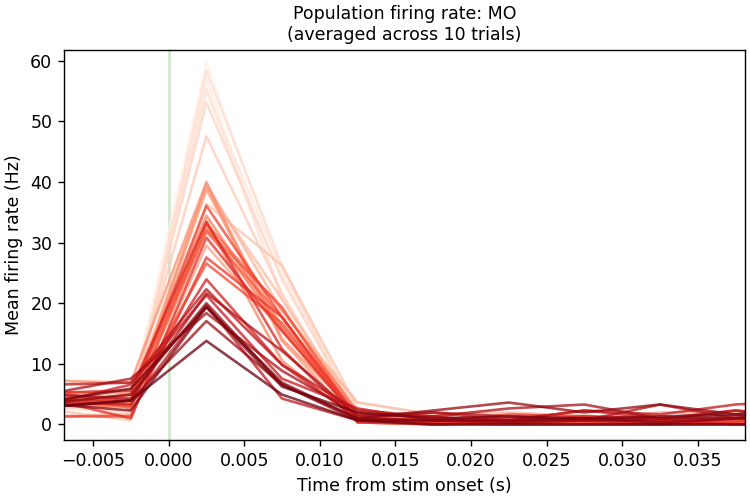

Text(0.5, 1.0, 'Population firing rate: MO\n(averaged across 10 trials)')

In [31]:
pwin = [-0.2, 0.4] # [-2.0, 2.0]

colors = plt.cm.Reds(np.linspace(0, 1, num_trial_sets+1))
fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
ax.axvline(0, color='g', alpha=0.2)
for ii in range(regi_popFR.shape[1]):
    ax.plot(timex, regi_popFR[:,ii], color=colors[ii+1], alpha=0.75)

ax.set_xlim(pwin)
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Mean firing rate (Hz)')
ax.set_title('Population firing rate: {}\n(averaged across {:d} trials)'.format(regi, n_mean))

<IPython.core.display.Javascript object>


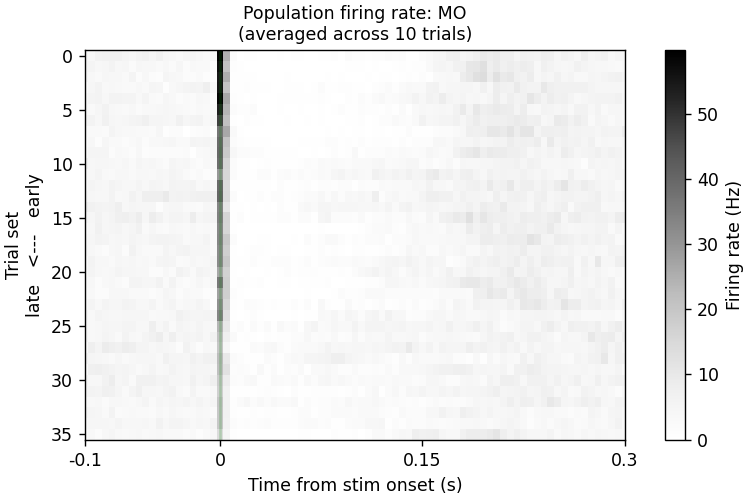

In [32]:
pwin = [-0.1, 0.3]

fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)

pwinind = [find_nearest_ind(timex, x) for x in pwin]
ax.axvline(find_nearest_ind(timex, 0), color='g', alpha=0.2)
vim = ax.imshow(regi_popFR.T, cmap='Greys', interpolation='none', aspect='auto', vmin=0, vmax=np.max(regi_popFR))
ax.set_xlim(pwinind)

new_ticks = [pwin[0], 0, np.mean([0, pwin[1]]), pwin[1]]
ax.set_xticks([find_nearest_ind(timex, x) for x in new_ticks])
ax.set_xticklabels(new_ticks)
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Trial set\nlate   <---   early')
ax.set_title('Population firing rate: {}\n(averaged across {:d} trials)'.format(regi, n_mean))

cb = fig.colorbar(vim, label='Firing rate (Hz)', ax=ax)